We will simulate convergent beam electron diffraction (CBED) patterns for Dicalcium aluminium alumosilicate (http://www.crystallography.net/cod/1000048.html). We first import the multislice library, read in and plot the crystal and set up some basic parameters for our simulation

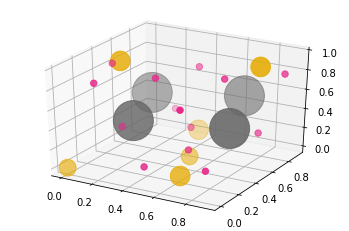

In [1]:
import pyms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Get crystal
crystal = pyms.crystal('Structures/1000048.p1',temperature_factor_units='B')

#Quick plot of crystal
crystal.quickplot()

#Subslicing of crystal for multislice
subslices = [0.33,0.66,1.0]
nsubslices = len(subslices)

#Grid size in pixels
gridshape = [1024,1024]
tiling = [32,32]

#Size of real space grid
rsize = np.zeros((3,))
rsize[:3]  = crystal.unitcell[:3]
rsize[:2] *= np.asarray(tiling)

#Number of transmission functions
nT = 4

#Probe accelerating voltage in eV
eV = 3e5

#Probe forming aperture in mrad
app = 3 

#Number of frozen phonon passes
nfph = 25

Set up and look at transmission functions

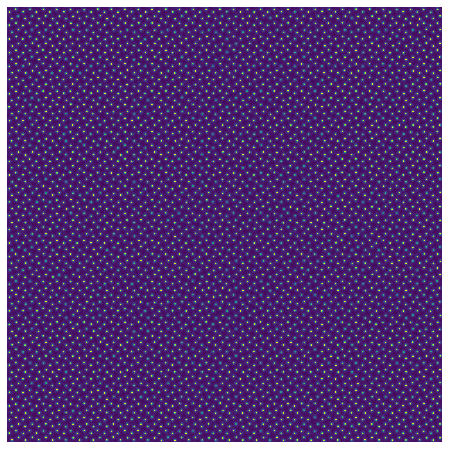

interactive(children=(IntSlider(value=0, description='Slice:', max=2), Output()), _dom_classes=('widget-intera…

/home/hamish/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


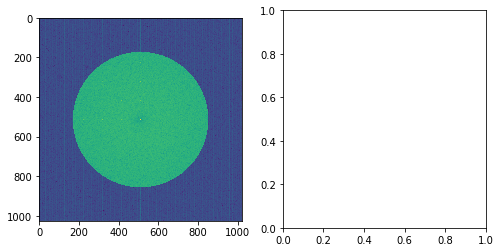

In [2]:
import torch
from pyms.utils import cx_to_numpy

#Choose GPU if available and CPU if not
if (torch.cuda.is_available()):
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
#Initialize array to store transmission functions in
T = torch.zeros(nT,nsubslices,*gridshape,2,device=device)

#Make transmission functions
for i in range(nT):
    T[i,:,:] = crystal.make_transmission_functions(gridshape,eV,subslices,tiling,fftout=True,device=device)
from PIL import Image
for i in range(nT):
    Image.fromarray(np.angle(cx_to_numpy(T[i,0,...]))).save('Trans/Trans{0}.tif'.format(i))
    
#Plot the different slices of the unit cell
fig,ax = plt.subplots(figsize=(8,8))
vmax=0.6*np.amax(np.angle(cx_to_numpy(T[0,1,...])))
vmin=np.amin(np.angle(cx_to_numpy(T[0,1,...])))
p = ax.imshow(np.angle(cx_to_numpy(T[0,1,...])),vmin=vmin,vmax=vmax)
ax.set_axis_off()

def plot_img(i,img,p,fig):
    p.set_data(np.angle(cx_to_numpy(img[0,i,...])))
    fig.canvas.draw_idle()
#     p.set_title()

widg = widgets.IntSlider(
    value=0,
    min=0,
    max=T.shape[1]-1,
    step=1,
    description='Slice:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
interact(plot_img,i=widg,img=fixed(T), p=fixed(p),fig=fixed(fig))


Now calculate CBED pattern and plot for a range of thicknesses

100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


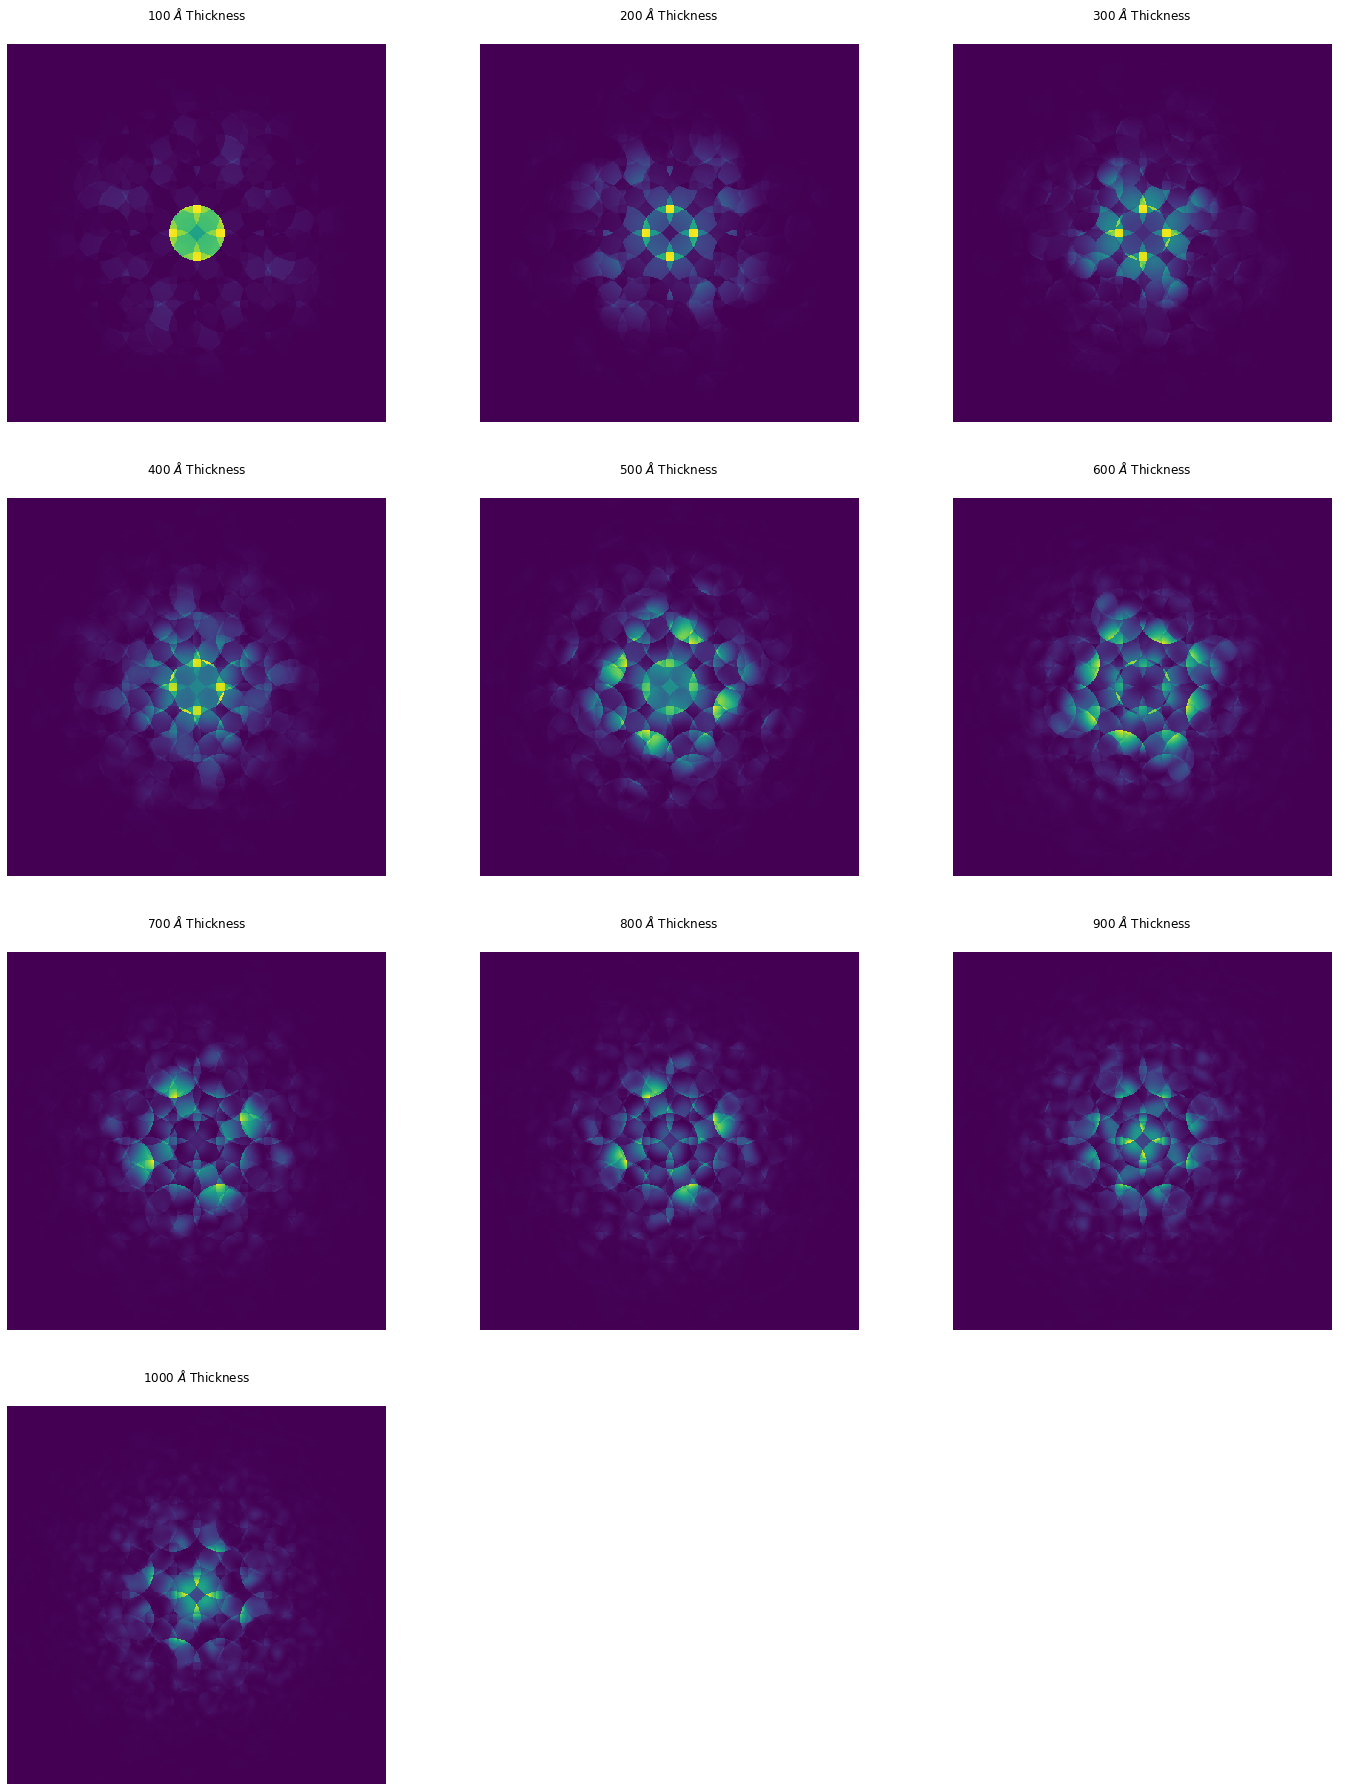

In [7]:
from tqdm import tqdm
import numpy as np

# Make Fresnel free-space propagators for multislice algorithm
propagators = pyms.make_propagators(gridshape,rsize,eV,subslices)

# Set up thickness series
tstep = 100
thicknesses = np.arange(tstep,1001,tstep)
nslices = np.asarray(np.ceil(thicknesses/crystal.unitcell[2]),dtype=np.int)

nt = thicknesses.shape[0]

nfph = 10

output = np.zeros((nt,*gridshape))



#Iteration over frozen phonon configurations
for ifph in tqdm(range(nfph)):
    # Make probe
    probe = pyms.focused_probe(gridshape,rsize,eV,app)
    tt = 0
    # Run multislice
    for it,t in enumerate(thicknesses):
        probe = pyms.multislice(probe,propagators,T,nslices[it]-tt,tiling=tiling,device_type=device)
        output[it,...] += np.abs(np.fft.fftshift(np.fft.fft2(probe,norm='ortho')))**2
        tt = nslices[it]

output/= nfph

# Set up montage to plot output
nn = int(np.ceil(np.sqrt(nt)))
figsize= 8
ncols = 3
nrows = int(np.ceil(nt/ncols))
fig,axes= plt.subplots(nrows=nrows,ncols=ncols,figsize=(figsize*ncols,figsize*nrows))

for i in range(nrows*ncols): axes[i//ncols,i%ncols].set_axis_off()        

# Helper function to crop output for viewing
def crop(array,outsize):
    insize = array.shape
    return array[(insize[0]-outsize[0])//2:(insize[0]+outsize[0])//2,
                 (insize[1]-outsize[1])//2:(insize[1]+outsize[1])//2]
probe = np.abs(pyms.focused_probe(gridshape,rsize,eV,app))**2
vmin,vmax = [np.amin(probe),np.amax(probe)]
# Plot output
for it,t in enumerate(thicknesses):
    ax = axes[it//ncols,it%ncols]
    ax.matshow(crop(output[it,...],[x//2 for x in gridshape]))
    ax.set_title('{0} $\\AA$ Thickness'.format(int(t)))
    